## Constrained Optimization Approach to Predictability Analysis in<br/> Bio-Mathematical Modeling

Ivan Borisov,<br/> 
Developer, InSysBio LLC

### Agenda

- Bio-Mathematical Modeling
- Validation of a Systems Biology model
- LikelihoodProfiler
- Taxol treatment model case study: assessing identifability and predictability

## A Systems Biology Model

A general kinetic systems biology (SB) model:
\begin{align}
\frac{dx(t)}{dt} & = f(x(t),\theta) \\
x(0) & = x_0 \\
y(t,\theta) & = g(x(t),\theta)+\epsilon(t)
\end{align}

- $x(t)$ - model's state variables
- $y(t, \theta)$ - the observables (output, experimentally observed quantities)
- $\epsilon(t)$ - the measurement error
- {$\theta, x_0$} - set of both known and unknown model's parameters

### Assessing model's credibility:

- Which parameters are structurally identifiable?
- Is experimental data sufficient to practically identify all the unknown parameters?
- What are the ranges for parameters variations?
- How reliable are the model's predictions?

## Identifiability Analysis with LikelihoodProfiler

LikelihoodProfiler (LP) https://github.com/insysbio/LikelihoodProfiler.jl
- Is a free software package for **Identifiability analysis** based on **Profile Likelihood** method and written in **Julia** language
- Transforms confidence intervals estimation into **“single-pass” constrained optimization problem**
- Is **fast** and **efficient** even for non-differentiable likelihood functions
- Implements **Confidence Intervals by Constrained Optimization** algorithm proposed in [Borisov I, Metelkin E (2020) Confidence intervals by constrained optimization—An algorithm and software package for practical identifiability analysis in systems biology](https://doi.org/10.1371/journal.pcbi.1008495)

## Cancer Taxol Treatment Model
Identifiability of this model was analyzed in [Marisa C.Eisenberg, Harsh V.Jain. A confidence building exercise in data and identifiability](https://www.sciencedirect.com/science/article/pii/S0022519317303454)


In [2]:
using DiffEqBase, OrdinaryDiffEq, Plots, NLopt, DataFrames, CSV, Distributions, LikelihoodProfiler
import Statistics: mean

const K   = 10.515*100
const V0  = 1.3907*K
const lam = 9.5722
const theta = 10.
const aRP  = 20.
const arstexp = 3.
const adthexp = 4.;

In [3]:
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_de.m
function ode_func(du, u, θ, t, drug)
    (a0, ka, r0, d0, kd) = (θ[1],θ[2],θ[3],θ[4],θ[5])

    Ncel = u[1] + u[2] + u[3]
    Lfac = ((K-Ncel)^theta)/((V0^theta) + ((K-Ncel)^theta))
    arst = a0*(drug^arstexp)/(ka^arstexp + (drug^arstexp))
    adth = d0*(drug^adthexp)/(kd^adthexp + (drug^adthexp))
    arcv = r0
    
    # The differential equations
    du[1] = -lam*u[1] + aRP*u[2]*Lfac - arst*u[1] + arcv*u[3]
    du[2] = 2*lam*u[1] - aRP*u[2]*Lfac
    du[3] = arst*u[1] - adth*u[3] - arcv*u[3]
end;

Let's load experimental data

In [4]:
df = CSV.read("taxol_data.csv", DataFrame)
dose = [5., 10., 40., 100.]

times = df.times
C005 = mean(df.Cell005)
C010 = mean(df.Cell010)
C040 = mean(df.Cell040)
C100 = mean(df.Cell100)

data = [df.Cell005/C005, df.Cell010/C010, df.Cell040/C040, df.Cell100/C100]
datamean = [C005, C010, C040, C100];

... and define the loss function
$$ \Lambda(\theta) = \sum_{i=1}^n \left( y(t_i,θ) - data_i \right)^2 $$

In [5]:
function lsq_func(θ)
    loss = 0.
    for (i,d) in enumerate(dose)
       prob = ODEProblem((du,u,θ,t)->ode_func(du,u,θ,t,d), u0, tspan, θ)
       sol = solve(prob, AutoTsit5(Rosenbrock23()), saveat=times)
        
       sim = (sol[1,:] + sol[2,:] + sol[3,:])/datamean[i]
       loss += sum((sim-data[i]).^2)
    end
    return loss
end;

Let's assume we have fitted the model to experimental data...

In [6]:
# best fit values
u0 = [7.2700, 2.5490, 0.]
θ0 = [8.3170, 8.0959, 0.0582, 1.3307, 119.1363]
tspan = (0.,15.);

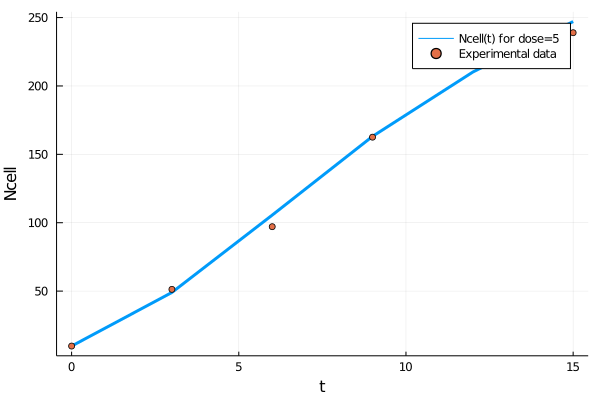

In [7]:
prob = ODEProblem((du,u,θ,t)->ode_func(du,u,θ,t,5.0), u0, tspan, θ0)
sol = solve(prob, AutoTsit5(Rosenbrock23()), saveat=times)

plot(sol.t, (sol[1,:]+sol[2,:]+sol[3,:]), xlabel = "t", ylabel = "Ncell", label="Ncell(t) for dose=5", line=3, fmt = :png);
scatter!(times, df.Cell005, label = "Experimental data")

Now it's time to check parameters **practical identifiability**. 
- Parameter $\theta_i$ is said to be practically identifiable if it's confidence interval (CI) is finite
- Parameters' confidence interval can be obtained with **profile likelihood** which  implies constructing likelihood-based CIs by exploring $\Lambda(\theta_i)$ as a function of a single parameter $\theta_i$ : $PL(\theta_i) = \min_{j\neq i}(\Lambda(\theta))$
- The confidence interval to a given confidence level $\alpha$ are $\theta_i$ values with $PL(\theta_i)$ below the threshold ($\alpha$-quantile of a $\chi^2$-distribution)
![](ident.jpg "Practical Identifiability")

#### LikelihoodProfiler (LP)
- Allows the users to identify the **endpoints of confidence intervals** without recovering the whole profile
- Obtaines the **endpoints of confidence intervals** as solutions to the constrained optimization problem

In [8]:
# likelihood threashold
sigmasq = (mean([(df.Cerr005/C005); (df.Cerr010/C010); (df.Cerr040/C040); (df.Cerr100/C100)]))^2
threshold = sigmasq*cquantile(Chisq(5), 0.05)

α = lsq_func(θ0) + threshold;

Let's estimate the confidence intervall for *a0* parameter

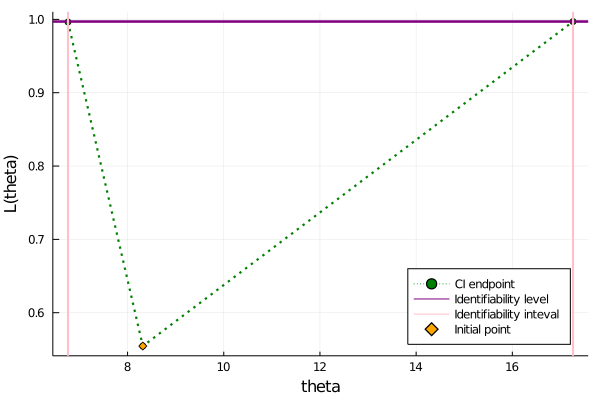

In [9]:
using LikelihoodProfiler

a0_ci = get_interval(θ0, 1, lsq_func,:CICO_ONE_PASS,
        loss_crit = α, scan_bounds = (1e-3,1e3), scale = fill(:log,length(θ0)))
plot(a0_ci, fmt = :png, legend=:bottomright)

We can enrich the profile with intermediate points to make smooth plot

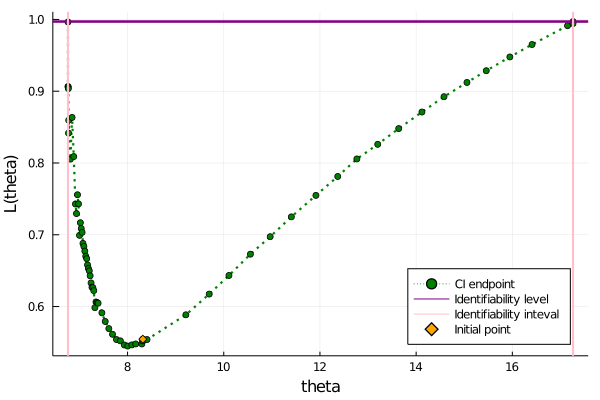

In [10]:
update_profile_points!(a0_ci)
plot(a0_ci, fmt = :png, legend=:bottomright)

**LikelihoodProfiler** usage can be extended to **confidence bands** estimation
- Confidence bands are **generalizations of confidence intervals** for arbitrary observables
- Construction of a confidence band implies estimating confidence intervals of an observable as function of all parameters $A(\theta)$ at given timepoints
- The confidence band to a given confidence level $\alpha$ are $A(\theta)$ values with $PL(\theta) = \Lambda(\theta)$ below the threshold ($\alpha$-quantile of a $\chi^2$-distribution)

Let's estimate confidence bands for *Ncell* observable and *dose=5*

In [11]:
function bands_func(parampampam, i, dose=5.0)
    prob = ODEProblem((du,u,θ,t)->ode_func(du,u,θ,t,dose), u0, tspan, parampampam)
    sol = solve(
        prob, 
        AutoTsit5(Rosenbrock23()), 
        saveat=times
    )
    return sol[1,i]+sol[2,i]+sol[3,i]
end;

In [12]:
intervals = Vector{ParamInterval}(undef,length(times))
for i in eachindex(times)
    @time intervals[i] = get_interval(θ0, θ->bands_func(θ,i), lsq_func, :CICO_ONE_PASS,
        loss_crit = α, scan_bounds = (1e-3,1e3), theta_bounds = fill((1e-3,1e3),length(θ0)),scale = fill(:log,length(θ0)))
end

  8.951276 seconds (9.89 M allocations: 654.626 MiB, 1.76% gc time, 96.90% compilation time)
 10.238887 seconds (18.00 M allocations: 1.366 GiB, 4.03% gc time)
 12.926473 seconds (22.93 M allocations: 1.738 GiB, 3.77% gc time)
 12.068383 seconds (21.98 M allocations: 1.663 GiB, 3.99% gc time)
 10.283547 seconds (18.50 M allocations: 1.404 GiB, 3.74% gc time)
 12.025768 seconds (21.85 M allocations: 1.650 GiB, 4.01% gc time)


Let' plot **confidence bands** for *Ncell* observable

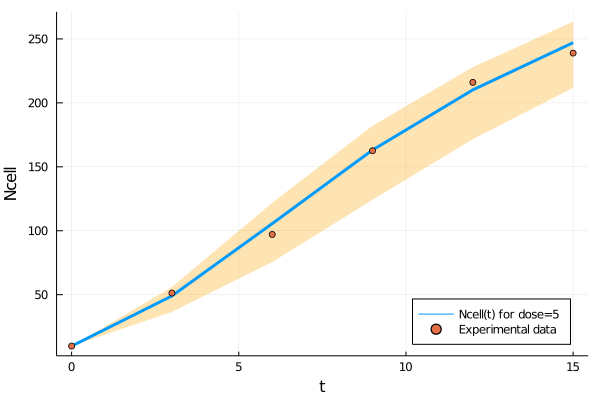

In [52]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = (sol[1,:]+sol[2,:]+sol[3,:])
plot(sol.t, u, xlabel = "t", ylabel = "Ncell", label="Ncell(t) for dose=5", line=3,
    ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3, fmt = :png, legend=:bottomright);
scatter!(times, df.Cell005, label = "Experimental data")

### Results

- **LikelihoodProfiler** application can be extended to predictability analysis and confidence bands estimation
- The efficacy of endpoint estimation without profile recovery becames espessially vivid in the case of **confidence bands**

### Links

- LikelihoodProfiler package https://github.com/insysbio/LikelihoodProfiler.jl
- Use-case and benchmark models https://github.com/insysbio/likelihoodprofiler-cases

### Roadmap

- Adapt the algorithm to other credability measurements, including predictive and validation bands
- Improve underlying optimization routines
- Contributions are welcome :)

##  <center> Thanks for your attention! </center>